# 2020-12-11 • KS test exponential distribution

As a little aside / exercising of comp-stats muscles, we test whether the inter-spike-intervals are really exponentially distributed (and hence the generated spike trains Poisson distibuted).

(they of course will be, as we generate the trains by drawing ISI's from an exponential distribution).

## Imports & time grid

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading:
 - numpy … (0.12 s)
 - matplotlib.pyplot … (0.24 s)
 - numba … (0.32 s)

Importing from submodules (compiling numba functions) … ✔

Imported `np`, `mpl`, `plt`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Tue 29 Dec** 2020, at 21:27 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/8e535019c7a3b9df975a1e9354cbabe15f26326d
) (Tue 29 Dec 2020, 21:26).

Uncommited changes to:
```
A  notebooks/2020-11-11__unitlib.ipynb
```

In [3]:
tg = v.TimeGrid(
    duration = 10 * minute,
    timestep = 0.1 * ms
);

## Spike trains

In [4]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

In [5]:
f_spike = 20 * Hz;

In [6]:
gen_st = v.generate_Poisson_spikes

v.fix_rng_seed()

In [7]:
%%time
spike_trains_connected = [gen_st(f_spike, tg.duration) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(f_spike, tg.duration) for _ in range(N_unconnected)];

Wall time: 18.3 ms


This was 1.77 seconds when generating full 0/1 signals. I.e. we got 10x speedup by switching to drawing ISI's from an exponential and only saving spike times.

In [8]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected;

In [9]:
time_slice = 1 * minute + np.array([0, 1]) * second

slice_indices = np.round(time_slice / tg.timestep).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.time[i_slice];

In [10]:
def plot_spike_train_excerpt(spike_train):
    return v.spike_trains.plot(spike_train, time_slice)

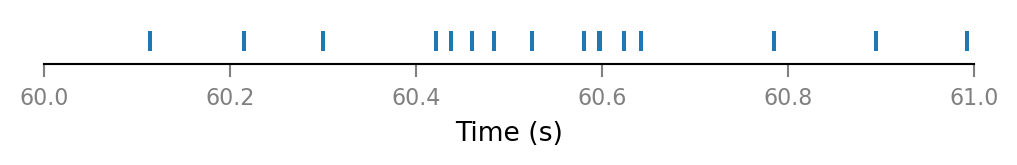

In [11]:
plot_spike_train_excerpt(all_spike_trains[0]);

## Test exponential distribution

Aight.

Check if spike train's are really Poisson; and thus that ISI's are exponentially distributed.

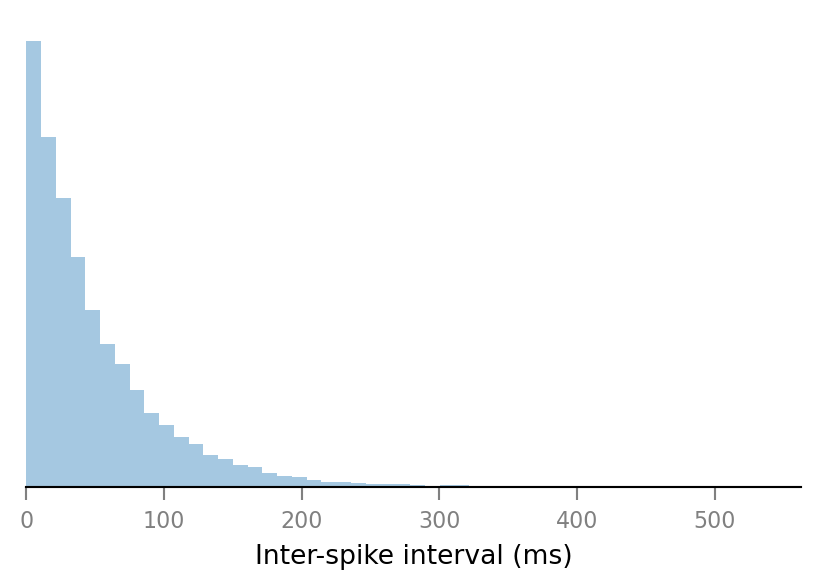

In [12]:
st = all_spike_trains[0]
ISIs = np.diff(st)

import seaborn as sns
ax = sns.distplot(ISIs / ms, kde=False, norm_hist=True)
ax.set_xlim(left=0)
ax.set_xlabel("Inter-spike interval (ms)")
ax.set_yticks([])
sns.despine(ax=ax, left=True);

Fit exponential:

In [13]:
from scipy.stats import expon

loc, scale = expon.fit(ISIs / ms)
loc, scale

(0.003623, 49.43)

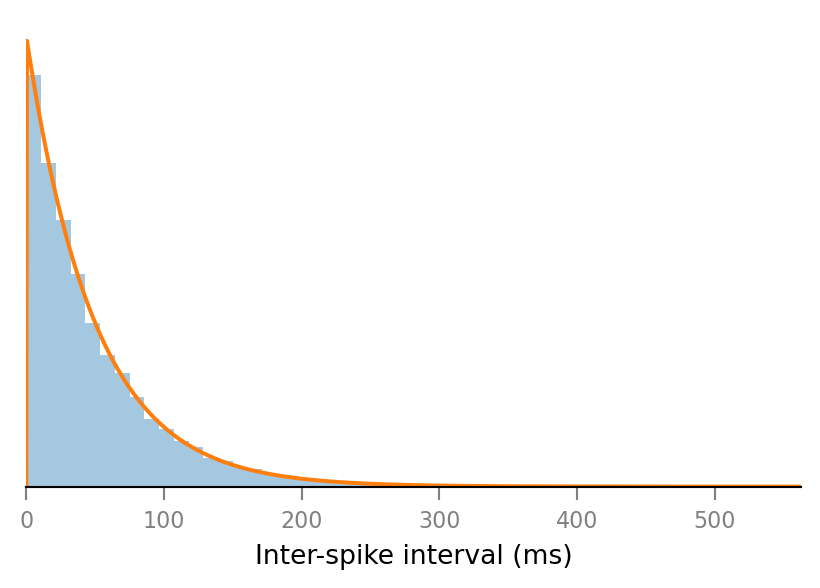

In [14]:
pdf = partial(expon.pdf, loc=loc, scale=scale)
x = np.linspace(*ax.get_xlim(), 1000)
ax.plot(x, pdf(x))
ax.figure

QQ plot

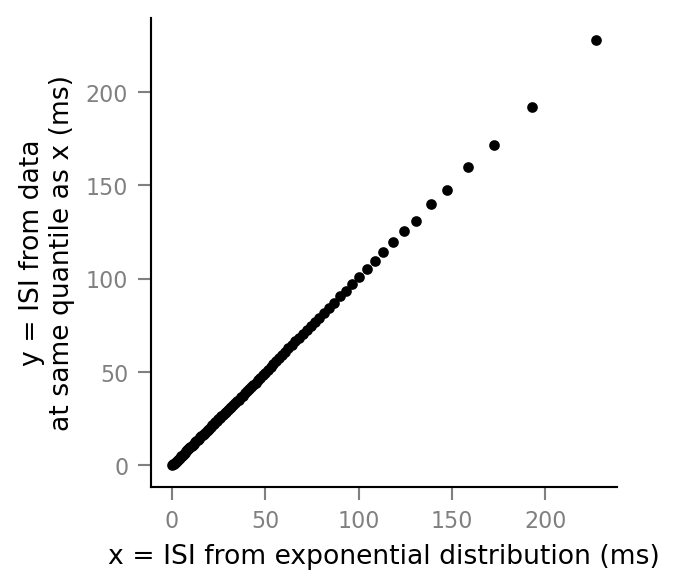

In [15]:
num_quantiles = 100  # i.e. we'll plot percentiles
quantiles = np.linspace(0, 1, num_quantiles)

fig, ax = plt.subplots()

for q in quantiles:
    x = expon.ppf(q, loc, scale)  # "ppf" = "percent point function" 
    #                             #       = inverse cdf = quantiles
    y = np.quantile(ISIs / ms, q)
    ax.plot(x, y, 'k.')

ax.set(
    aspect='equal',
    xlabel='x = ISI from exponential distribution (ms)',
    ylabel='y = ISI from data\n'
           'at same quantile as x (ms)'
);

Straight line: it fits 😮.

CDF comparison

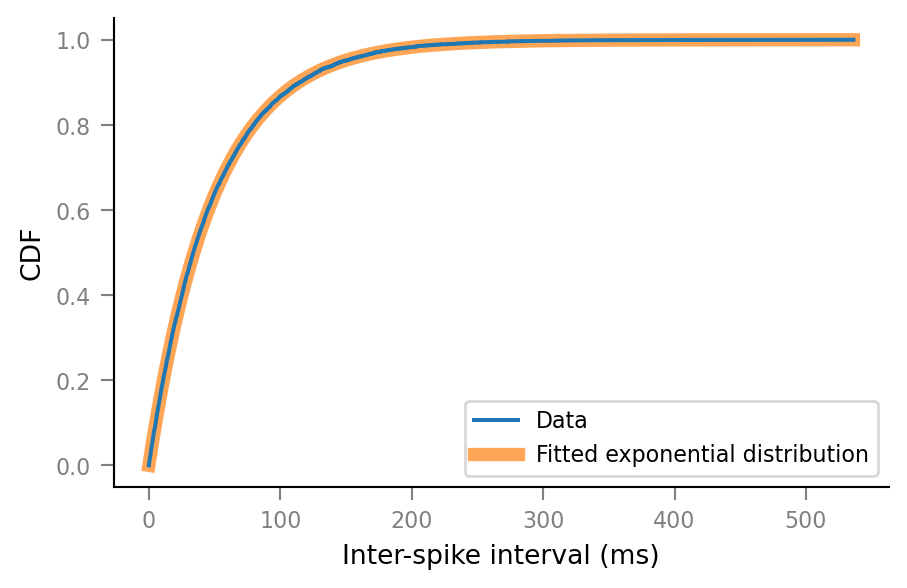

In [16]:
fig, ax = plt.subplots()

x_data = sorted_ISIs = np.sort(ISIs / ms)
y_data = np.linspace(0, 1, len(x_data))
ax.step(x_data, y_data, label="Data")

x_pdf = np.linspace(sorted_ISIs[0], sorted_ISIs[-1], 1000)
y_pdf = expon.cdf(x_pdf, loc, scale)
bg_kwargs = dict(alpha=0.7, lw=5, zorder=0)
ax.plot(x_pdf, y_pdf, label="Fitted exponential distribution", **bg_kwargs)

ax.set(
    xlabel="Inter-spike interval (ms)",
    ylabel="CDF",
)
ax.legend();

Zoom in:

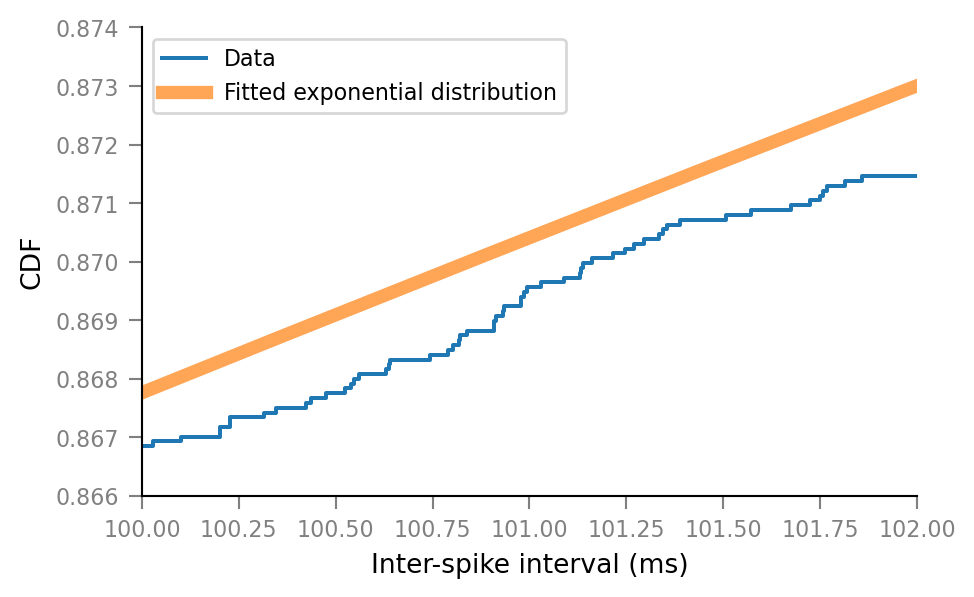

In [17]:
xlim_orig = ax.get_xlim()
ylim_orig = ax.get_ylim()
xlim_superzoom = (100, 102)
ylim_superzoom = (0.866, 0.874)
ax.set(xlim=xlim_superzoom, ylim=ylim_superzoom)
ax.figure

Combine zoomed views with original plot.

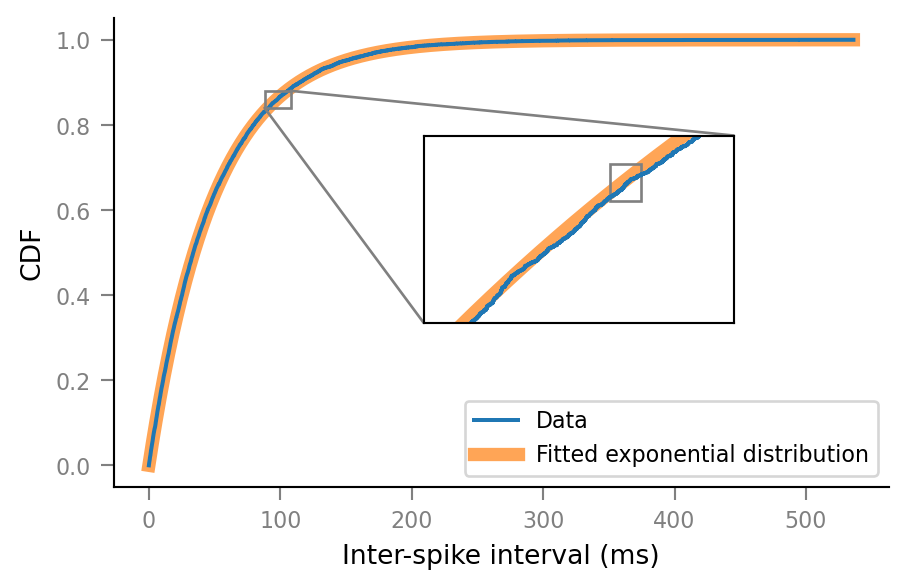

In [18]:
ax.set(xlim=xlim_orig, ylim=ylim_orig)
in_ax = ax.inset_axes([0.4, 0.35, 0.4, 0.4])
sns.despine(ax=in_ax, top=False, right=False)
in_ax.step(x_data, y_data)
in_ax.plot(x_pdf, y_pdf, **bg_kwargs)
xlim_medium_zoom = (88, 108)
ylim_medium_zoom = (0.84, 0.88)
in_ax.set(xlim=xlim_medium_zoom, ylim=ylim_medium_zoom)
ax.indicate_inset_zoom(in_ax, alpha=1)
in_ax.set_xticks([])
in_ax.set_yticks([])
# Mark superzoom of above _inside_ inset.
# 
# `in_ax.indicate_inset` doesn't work for some reason.
# Hence the manual Rectangle.
in_ax.add_patch(
    mpl.patches.Rectangle(
        xy=(xlim_superzoom[0], ylim_superzoom[0]),
        width=np.diff(xlim_superzoom).item(),
        height=np.diff(ylim_superzoom).item(),
        ec='grey',
        fill=False,
))
ax.figure

Quantify distance between CDF's with (two-sided) Kolmogorov-Smirnov test.

KS test statistic is maximum vertical distance between CDF's.\
p-value is calculated based on this statistic and the [Kolmogorov distribution](https://www.wikiwand.com/en/Kolmogorov%E2%80%93Smirnov_test#/Kolmogorov_distribution)
([SciPy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ksone.html#scipy.stats.ksone))
-- which in turn is based on Brownian motion i.e. random walks.

In [19]:
from scipy.stats import kstest
kstest(ISIs / ms, expon.cdf, (loc, scale))

KstestResult(statistic=0.005775131258583199, pvalue=0.8107313119920425)

We reject H1 that the data is not drawn from an exponential distribution ($p \gg 0.05$).

Addendum: this statistical analysis is not entirely correct, 
because the KS test assumes that the parameters of the probability distribution
are not determined from the data (as we have done here).
Some correction to the statistic/p-value would be needed to correct for that

## Repro info

In [20]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Tue 29 Dec** 2020, at 21:27 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/8e535019c7a3b9df975a1e9354cbabe15f26326d
) (Tue 29 Dec 2020, 21:26).

Uncommited changes to:
```
A  notebooks/2020-11-11__unitlib.ipynb
```

Platform:

Windows-10
CPython 3.8.3 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.2
numba                0.51.2
seaborn              0.10.1
scipy                1.5.2
scikit-learn         0.23.2
preload              2.1
py-cpuinfo           7.0.0
nptyping             1.3.0
